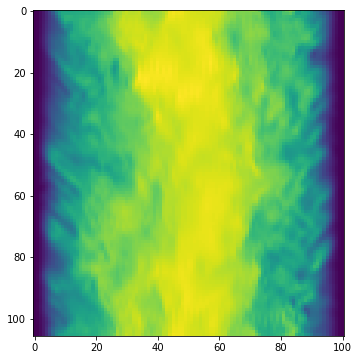

In [4]:
import numpy as np

from weight import *
from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

import h5py
#with h5py.File('NSE2D/channelflow_l2.mat', 'r') as mat:
#with h5py.File('NSE2D/channelflow_lam.mat', 'r') as mat:
with h5py.File('NSE2D/channelflow.mat', 'r') as mat:
    P = np.array(mat['P'])
    U = np.array(mat['U'])
    V = np.array(mat['V'])
    W = np.array(mat['W'])
    X = np.array(mat['X'])[0]
    Y = np.array(mat['Y'])[0]
    Z = np.array(mat['Z'])[0]
    T = np.array(mat['T'])

# indices come out horribly wrong for some reason
P = np.transpose(P)
U = np.transpose(U)
V = np.transpose(V)
W = np.transpose(W)

Nx = len(X); Ny = len(Y); Nz = len(Z); Nt = len(T)
dx = X[1]-X[0]; dz = Z[1]-Z[0]; dt = (T[1]-T[0])[0]

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(U[:, :, 32, 0])

In [5]:
#testing
#U = np.einsum('i,j,k->ijk', X, Y**0, np.transpose(T**0)[0])
#V = np.einsum('i,j,k->ijk', X**0, -Y, np.transpose(T**0)[0])
#W = np.zeros(U.shape)

#fig, ax= plt.subplots(figsize=(6,6))
#ax.imshow(V[:, :, 0])

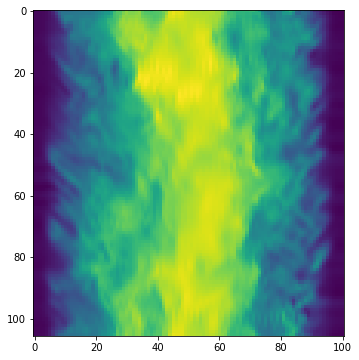

In [6]:
fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, :, 32, 0])

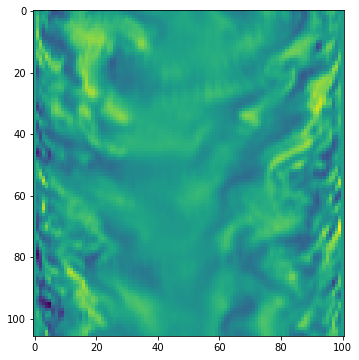

In [7]:
from utils import resample_grid

# Y is still reversed
#if Y[0] > Y[-1]:
#    Y = Y[::-1]
y_resample = np.linspace(min(Y[0], Y[-1]), max(Y[0], Y[-1]), Ny)
dy = y_resample[1]-y_resample[0]
p = resample_grid(P, Y, y_resample, axis=1, order=3)
#p = np.zeros(U.shape)
u = resample_grid(U, Y, y_resample, axis=1, order=3)
v = resample_grid(V, Y, y_resample, axis=1, order=3)
w = resample_grid(W, Y, y_resample, axis=1, order=3)

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(w[:, :, 32, 0])
#ax.imshow(v[:, :, 0])

In [8]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)
observables = [uobs, pobs]

#u_vec = np.concatenate([u[:, :, :, np.newaxis], v[:, :, :, np.newaxis]], axis=3)
u_vec = np.concatenate([u[:, :, :, :, np.newaxis], v[:, :, :, :, np.newaxis], w[:, :, :, :, np.newaxis]], axis=4)

### define all parameters and "make library"
terms = generate_terms_to(3, observables=observables, max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(u.shape)
m = 16
qmax = 1
nweights = qmax**4
ndomains = 30 #250
wx = 30
wt = 30
pad = 0


In [9]:
%%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': p, 'u': u_vec}

#dxs = [dx, dy, dt]
dxs = [dx, dy, dz, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
#dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dy, (wt-1)/2*dt]
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dy, (wx-1)/2*dz, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                #weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
                weights.append(Weight([m]*4, [q1, q2, q3, q4], [0]*4, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
#domains = make_domains([wx, wx, wt], world_size, ndomains, pad)
domains = make_domains([wx, wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=True)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=True)#, by_parts=False)

***RANK 0 LIBRARY***

i: 0
UNINDEXED TERM:
1
LibraryTerm 1
Value:  1554.6958489300177

i: 1
UNINDEXED TERM:
dj u_j
ORIGINAL TERM:
dx u_x [[1, 0, 0, 0]]
INTEGRATED BY PARTS:
u_x [[0, 0, 0, 0]] Weight([16, 16, 16, 16], [0, 0, 0, 0], [1, 0, 0, 0], -1, [0.41037735849056606, 0.29000000000000026, 0.34523809523809523, 0.145])
LibraryTerm u_x
ORIGINAL TERM:
dy u_y [[0, 1, 0, 0]]
INTEGRATED BY PARTS:
u_y [[0, 0, 0, 0]] Weight([16, 16, 16, 16], [0, 0, 0, 0], [0, 1, 0, 0], -1, [0.41037735849056606, 0.29000000000000026, 0.34523809523809523, 0.145])
LibraryTerm u_y
ORIGINAL TERM:
dz u_z [[0, 0, 1, 0]]
INTEGRATED BY PARTS:
u_z [[0, 0, 0, 0]] Weight([16, 16, 16, 16], [0, 0, 0, 0], [0, 0, 1, 0], -1, [0.41037735849056606, 0.29000000000000026, 0.34523809523809523, 0.145])
LibraryTerm u_z
Value:  -0.4444755460748834

i: 2
UNINDEXED TERM:
dt dj u_j
ORIGINAL TERM:
dt dx u_x [[1, 0, 0, 1]]
INTEGRATED BY PARTS:
u_x [[0, 0, 0, 0]] Weight([16, 16, 16, 16], [0, 0, 0, 0], [1, 0, 0, 1], 1, [0.41037735849056606, 0

         1412931 function calls (1350521 primitive calls) in 277.791 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2160   83.767    0.039   83.786    0.039 diff.py:478(_apply_to_array)
        2   55.611   27.805  274.451  137.226 process_library_terms.py:263(make_library)
     7200   47.760    0.007   49.947    0.007 function_base.py:4129(trapz)
     3180   38.515    0.012  168.607    0.053 process_library_terms.py:173(eval_term)
101133/45985   20.714    0.000   76.166    0.002 {built-in method numpy.core._multiarray_umath.implement_array_function}
     3180   14.087    0.004   30.951    0.010 process_library_terms.py:34(get_weight_array)
    39785    3.913    0.000    3.913    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    12720    2.869    0.000    2.945    0.000 polynomial.py:664(polyval)
      720    2.243    0.003   88.953    0.124 diff.py:277(diff)
      720    0.947    0.001   89.903    0.125 diff.py:24

In [14]:
from identify_models import *

opts = dict()
opts['threshold'] = "'threshold'"
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
opts1 = opts.copy()
opts1['char_sizes'] = char_sizes1
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([Q0, Q1], [opts, opts1], [terms0, terms1],
                                                        observables, threshold=1e-3)

[0.01 s]
Identified model: 1.0 * dj u_j = 0 (order 2, residual 9.59e-04)
[0.03 s]
Identified model: -0.5215833819453575 * p + 1.0 * p * p + -0.49810893523681793 * p * u_j * u_j + 0.25972556367145844 * u_j * u_j = 0 (order 3, residual 2.49e-04)
[0.06 s]
Identified model: 0.09346134533946089 * 1 + -0.537730830850706 * p + 1.0 * p * p + -0.6035265347846003 * p * p * p = 0 (order 3, residual 4.15e-04)


In [15]:
from sparse_reg import *
#from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 #apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, **opts)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

In [ ]:
opts['char_sizes'] = char_sizes1
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

In [ ]:
avoid = []
avoid.append(Xi)
opts['avoid'] = avoid
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

In [ ]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)